In [180]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

In [181]:
df = pd.read_csv('./data/sample.csv')

In [182]:
df

,action_taken_name,agency_name,applicant_ethnicity_name,applicant_race_name_1,applicant_sex_name,applicant_income_000s,co_applicant_ethnicity_name,co_applicant_race_name_1,co_applicant_sex_name,county_name,...,owner_occupancy_name,preapproval_name,property_type_name,purchaser_type_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population
0,Application denied by financial institution,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,176.0,No co-applicant,No co-applicant,No co-applicant,Chautauqua County,...,Not owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,235,2605.0,930.0,6.850000,2979.0
1,Application withdrawn by applicant,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,53.0,No co-applicant,No co-applicant,No co-applicant,Erie County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,69000.0,108,2053.0,821.0,33.580002,4416.0
2,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Male,223.0,Not Hispanic or Latino,White,Female,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,659,497.0,387.0,49.959999,1363.0
3,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,Asian,Female,43.0,No co-applicant,No co-applicant,No co-applicant,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,103,251.0,558.0,32.090000,1960.0
4,Loan originated,National Credit Union Administration,Not Hispanic or Latino,White,Male,72.0,No co-applicant,No co-applicant,No co-applicant,Steuben County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,45,1514.0,1003.0,2.120000,3391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175857,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,118.0,No co-applicant,No co-applicant,No co-applicant,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Affiliate institution,109000.0,300,1470.0,1337.0,17.110001,4448.0
175858,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Female,27.0,No co-applicant,No co-applicant,No co-applicant,Monroe County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,"Life insurance company, credit union, mortgage...",69700.0,88,1719.0,1490.0,16.040001,4658.0
175859,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,215.0,Not Hispanic or Latino,White,Female,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,Fannie Mae (FNMA),109000.0,205,1547.0,1455.0,7.730000,4671.0
175860,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,116.0,No co-applicant,No co-applicant,No co-applicant,Rockland County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Freddie Mac (FHLMC),71300.0,200,1743.0,1534.0,19.969999,5484.0


In [183]:
# Overview over null values

null_df = pd.DataFrame({'Null_Values': df.isna().sum(), 'Percentage': round((df.isna().sum())/(df.shape[0])*(100),2)}).reset_index(drop = True)
null_df

,Null_Values,Percentage
0,0,0.00
1,0,0.00
2,0,0.00
3,0,0.00
4,0,0.00
5,24518,13.94
6,0,0.00
7,0,0.00
8,0,0.00
9,485,0.28


In [184]:
df['action_taken_name'].groupby(df.action_taken_name).count()

action_taken_name
Application approved but not accepted                   5743
Application denied by financial institution            32005
Application withdrawn by applicant                     15765
File closed for incompleteness                          6682
Loan originated                                        90982
Loan purchased by the institution                      24682
Preapproval request denied by financial institution        3
Name: action_taken_name, dtype: int64

In [186]:
# Filling null values 

df.county_name = df.county_name.fillna('No information')
df.msamd_name = df.msamd_name.fillna('No information')
df.denial_reason_name_1 = df.denial_reason_name_1.fillna(0)
df.denial_reason_name_2 = df.denial_reason_name_2.fillna(0)
df.denial_reason_name_3 = df.denial_reason_name_3.fillna(0)
df.applicant_income_000s = df.applicant_income_000s.fillna(df.applicant_income_000s.mean()).astype(int)
df.hud_median_family_income = df.hud_median_family_income.fillna(df.hud_median_family_income.mean()).astype(int)
df.minority_population = df.minority_population.fillna(df.minority_population.mean())
df.number_of_1_to_4_family_units = df.number_of_1_to_4_family_units.fillna(df.number_of_1_to_4_family_units.mean()).astype(int)
df.number_of_owner_occupied_units = df.number_of_owner_occupied_units.fillna(df.number_of_owner_occupied_units.mean()).astype(int)
df.population = df.population.fillna(df.population.mean()).astype(int)

In [187]:
# Converting columns from str to int without typing them as category

# I combine the 2 status' 'Loan originated' and 'Application approved but not accepted'. 
# My understanding is that the application was approved by the lender but not accepted by the applicant.
df.action_taken_name = df.action_taken_name.map({'Application denied by financial institution': 0, 'Preapproval request denied by financial institution': 0, 'File closed for incompleteness': 1, 'Application withdrawn by applicant': 2, 'Loan purchased by the institution': 3, 'Application approved but not accepted': 4, 'Loan originated': 4})

# Converting columns manually for the same order of information with applicant and co-applicant, labelling them astype('category)

df.applicant_ethnicity_name = df.applicant_ethnicity_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Not Hispanic or Latino': 1, 'Hispanic or Latino': 2, 'Not applicable': 3})
df.applicant_race_name_1 = df.applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6})
df.applicant_sex_name = df.applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3})
df.co_applicant_ethnicity_name = df.co_applicant_ethnicity_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Not Hispanic or Latino': 1, 'Hispanic or Latino': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.co_applicant_race_name_1 = df.co_applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6, 'No co-applicant': 7})
df.co_applicant_sex_name = df.co_applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.denial_reason_name_1 = df.denial_reason_name_1.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_2 = df.denial_reason_name_2.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_3 = df.denial_reason_name_3.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})


In [188]:
# Converting several columns from str to int, labelling some of them astype('category)

column_list = [1, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21]

for i in column_list:
    df.iloc[:,i] = pd.Categorical(df.iloc[:,i], ordered=True).codes
    # df.iloc[:,i] = df.iloc[:,i].astype('category')

In [189]:
df.dtypes

action_taken_name                   int64
agency_name                          int8
applicant_ethnicity_name            int64
applicant_race_name_1               int64
applicant_sex_name                  int64
applicant_income_000s               int32
co_applicant_ethnicity_name         int64
co_applicant_race_name_1            int64
co_applicant_sex_name               int64
county_name                          int8
denial_reason_name_1                int64
denial_reason_name_2                int64
denial_reason_name_3                int64
hoepa_status_name                    int8
lien_status_name                     int8
loan_purpose_name                    int8
loan_type_name                       int8
msamd_name                           int8
owner_occupancy_name                 int8
preapproval_name                     int8
property_type_name                   int8
purchaser_type_name                  int8
hud_median_family_income            int32
loan_amount_000s                  

<AxesSubplot:>

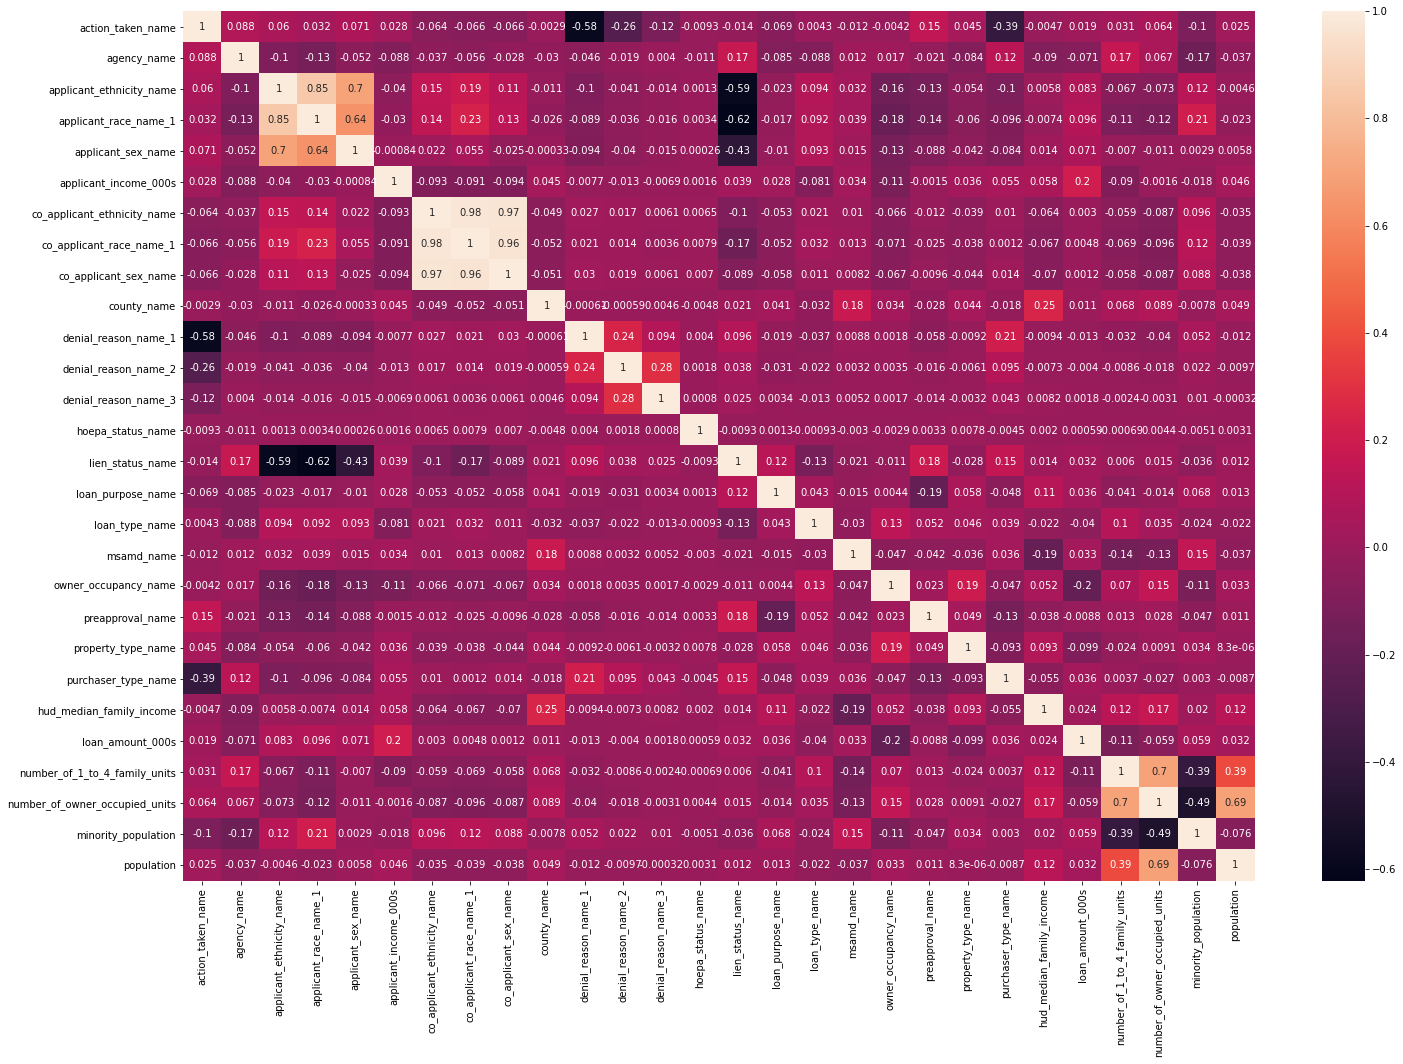

In [190]:
fig, ax = plt.subplots(figsize=(24, 16)) 
sns.heatmap(df.corr(), annot=True, ax = ax)

In [191]:
df.var()

action_taken_name                 2.403476e+00
agency_name                       2.723252e+00
applicant_ethnicity_name          5.795168e-01
applicant_race_name_1             2.909783e+00
applicant_sex_name                5.531276e-01
applicant_income_000s             6.420065e+04
co_applicant_ethnicity_name       2.143206e+00
co_applicant_race_name_1          8.174385e+00
co_applicant_sex_name             1.895167e+00
county_name                       2.541273e+02
denial_reason_name_1              1.813947e+00
denial_reason_name_2              4.989839e-01
denial_reason_name_3              1.107206e-01
hoepa_status_name                 1.535094e-04
lien_status_name                  5.560446e-01
loan_purpose_name                 4.161234e-01
loan_type_name                    4.669448e-01
msamd_name                        1.121180e+01
owner_occupancy_name              1.346682e-01
preapproval_name                  2.045008e-01
property_type_name                7.737123e-02
purchaser_typ

In [192]:
# Correlation depending on loan_approved

df.corr()['action_taken_name'].abs().sort_values(ascending = False)

action_taken_name                 1.000000
denial_reason_name_1              0.584101
purchaser_type_name               0.390901
denial_reason_name_2              0.264302
preapproval_name                  0.145839
denial_reason_name_3              0.118738
minority_population               0.103280
agency_name                       0.088279
applicant_sex_name                0.070740
loan_purpose_name                 0.069479
co_applicant_race_name_1          0.066272
co_applicant_sex_name             0.065995
co_applicant_ethnicity_name       0.064380
number_of_owner_occupied_units    0.063884
applicant_ethnicity_name          0.060457
property_type_name                0.044970
applicant_race_name_1             0.031915
number_of_1_to_4_family_units     0.031155
applicant_income_000s             0.027714
population                        0.025383
loan_amount_000s                  0.018751
lien_status_name                  0.014092
msamd_name                        0.011829
hoepa_statu

In [193]:
X = df.drop(['action_taken_name'], axis = 1)
y = df['action_taken_name']
y = np.array(y)

In [194]:
# How many denied or approved loans does the dataset contain?

print('0 - Application denied by financial institution\n', '1 - File closed for incompleteness\n', '2 - Application withdrawn by applicant\n', '3 - Loan purchased by the institution\n', '4 - Application approved but not accepted\n', '4 - Loan originated\n')
print('Distribution: \n' + str(pd.Series(y).value_counts()))
print('In Percent: \n' + str(pd.Series(y).value_counts() / pd.Series(y).count() * 100))

0 - Application denied by financial institution
 1 - File closed for incompleteness
 2 - Application withdrawn by applicant
 3 - Loan purchased by the institution
 4 - Application approved but not accepted
 4 - Loan originated

Distribution: 
4    96725
0    32005
3    24682
2    15765
1     6682
dtype: int64
In Percent: 
4    55.001450
0    18.199239
3    14.035108
2     8.964568
1     3.799635
dtype: float64


In [195]:
# The dataset is obviously very imbalanced. 
# A prediction with a high accuracy and Kappa is therefor only possible with a lot of try and error in feature optimization and / or oversampling. 

# I continue here with the original data.

In [197]:
# Scaling 

X_scaled = StandardScaler().fit_transform(X)

# Training

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 3)

In [198]:
# # After Oversampling

# print('Distribution after Oversampling: \n' + str(pd.Series(y_resampled).value_counts()))

In [199]:
# Logistic Regression
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr_prediction = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, model_lr_prediction)

conf_lr = confusion_matrix(y_test, model_lr_prediction)
clf_report_lr = classification_report(y_test, model_lr_prediction)

print(f"Accuracy Score of Logistic Regression is : {accuracy_lr}")
print(f"Confusion Matrix : \n{conf_lr}")
print(f"Classification Report : \n{clf_report_lr}")

Accuracy Score of Logistic Regression is : 0.8154895939952235
Confusion Matrix : 
[[ 5773     0    76     0  2029]
 [   10     1    87     0  1553]
 [   24     1   131     0  3807]
 [    0     0     0  6187     0]
 [   61     0   464     0 23761]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      7878
           1       0.50      0.00      0.00      1651
           2       0.17      0.03      0.06      3963
           3       1.00      1.00      1.00      6187
           4       0.76      0.98      0.86     24286

    accuracy                           0.82     43965
   macro avg       0.68      0.55      0.55     43965
weighted avg       0.77      0.82      0.77     43965



C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [200]:
kappa_lr = cohen_kappa_score(y_test, model_lr_prediction)
kappa_lr

0.6724724617823615

In [201]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=1500).fit(X_train, y_train)
model_rf_prediction = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, model_rf_prediction)

conf_rf = confusion_matrix(y_test, model_rf_prediction)
clf_report_rf = classification_report(y_test, model_rf_prediction)

print(f"Accuracy Score of Random Forest is : {accuracy_rf}")
print(f"Confusion Matrix : \n{conf_rf}")
print(f"Classification Report : \n{clf_report_rf}")

Accuracy Score of Random Forest is : 0.848811554645741
Confusion Matrix : 
[[ 6622    50   523     0   683]
 [  179   176   430     0   866]
 [  466   131  1243     0  2123]
 [    0     0     0  6187     0]
 [  331   118   747     0 23090]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      7878
           1       0.37      0.11      0.17      1651
           2       0.42      0.31      0.36      3963
           3       1.00      1.00      1.00      6187
           4       0.86      0.95      0.90     24286

    accuracy                           0.85     43965
   macro avg       0.71      0.64      0.66     43965
weighted avg       0.83      0.85      0.83     43965



In [202]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)
kappa_rf

0.750736638081142

In [203]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)

conf_dt = confusion_matrix(y_test, model_dt_prediction)
clf_report_dt = classification_report(y_test, model_dt_prediction)

print(f"Accuracy Score of Decision Tree is : {accuracy_dt}")
print(f"Confusion Matrix : \n{conf_dt}")
print(f"Classification Report : \n{clf_report_dt}")

Accuracy Score of Decision Tree is : 0.808552257477539
Confusion Matrix : 
[[ 6544   154   569     0   611]
 [  212   340   463     0   636]
 [  525   501  1322     0  1615]
 [    0     0     0  6187     0]
 [  687   697  1747     0 21155]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      7878
           1       0.20      0.21      0.20      1651
           2       0.32      0.33      0.33      3963
           3       1.00      1.00      1.00      6187
           4       0.88      0.87      0.88     24286

    accuracy                           0.81     43965
   macro avg       0.65      0.65      0.65     43965
weighted avg       0.81      0.81      0.81     43965



In [204]:
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.6990329090395178

Maximum:  0.8651877133105802
Mean:  0.8385528409432276


<AxesSubplot:>

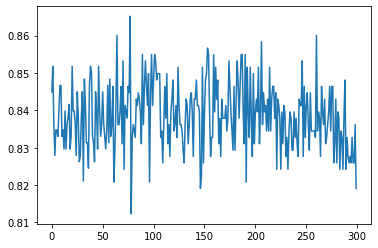

In [205]:
# K-Fold DecisionTree
model_kfdt = cross_val_score(tree.DecisionTreeClassifier(max_depth = 7), X, y, cv=300)
print('Maximum: ', model_kfdt.max())
print('Mean: ', model_kfdt.mean())

model_kfdt = pd.Series(model_kfdt)
model_kfdt.plot()

In [206]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2).fit(X_train, y_train)
model_knn_prediction = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, model_knn_prediction)

conf_knn = confusion_matrix(y_test, model_knn_prediction)
clf_report_knn = classification_report(y_test, model_knn_prediction)

print(f"Accuracy Score of KNN is : {accuracy_knn}")
print(f"Confusion Matrix : \n{conf_knn}")
print(f"Classification Report : \n{clf_report_knn}")

Accuracy Score of Ada Boost Classifier is : 0.7888320254748095
Confusion Matrix : 
[[ 5788   168   517     0  1405]
 [  281   241   345     0   784]
 [  622   301   881     0  2159]
 [    7     1     3  6158    18]
 [  912   482  1278     1 21613]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      7878
           1       0.20      0.15      0.17      1651
           2       0.29      0.22      0.25      3963
           3       1.00      1.00      1.00      6187
           4       0.83      0.89      0.86     24286

    accuracy                           0.79     43965
   macro avg       0.62      0.60      0.61     43965
weighted avg       0.77      0.79      0.78     43965



In [207]:
kappa_knn = cohen_kappa_score(y_test, model_knn_prediction)
kappa_knn

0.656994544388739

In [208]:
# Ada Boost
model_ada = AdaBoostClassifier(n_estimators = 1000).fit(X_train, y_train)
model_ada_prediction = model_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, model_ada_prediction)

conf_ada = confusion_matrix(y_test, model_ada_prediction)
clf_report_ada = classification_report(y_test, model_ada_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_ada}")
print(f"Confusion Matrix : \n{conf_ada}")
print(f"Classification Report : \n{clf_report_ada}")

Accuracy Score of Ada Boost Classifier is : 0.8360514045263278
Confusion Matrix : 
[[ 6630    57   512     0   679]
 [  214   139   353     0   945]
 [  642   214   812     0  2295]
 [    0     0     0  6187     0]
 [  550   155   592     0 22989]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      7878
           1       0.25      0.08      0.13      1651
           2       0.36      0.20      0.26      3963
           3       1.00      1.00      1.00      6187
           4       0.85      0.95      0.90     24286

    accuracy                           0.84     43965
   macro avg       0.66      0.62      0.62     43965
weighted avg       0.80      0.84      0.81     43965



In [209]:
kappa_ada = cohen_kappa_score(y_test, model_ada_prediction)
kappa_ada

0.72866364927706

In [210]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
model_gb_prediction = model_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, model_gb_prediction)
conf_gb = confusion_matrix(y_test, model_gb_prediction)
clf_report_gb = classification_report(y_test, model_gb_prediction)

print(f"Accuracy Score of Gradient Boosting Classifier is : {accuracy_gb}")
print(f"Confusion Matrix : \n{conf_gb}")
print(f"Classification Report : \n{clf_report_gb}")

Accuracy Score of Ada Boost Classifier is : 0.8476742863641533
Confusion Matrix : 
[[ 6601     5   597     0   675]
 [  175    41   420     0  1015]
 [  451    14  1129     0  2369]
 [    0     0     0  6187     0]
 [  307    11   658     0 23310]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7878
           1       0.58      0.02      0.05      1651
           2       0.40      0.28      0.33      3963
           3       1.00      1.00      1.00      6187
           4       0.85      0.96      0.90     24286

    accuracy                           0.85     43965
   macro avg       0.74      0.62      0.63     43965
weighted avg       0.83      0.85      0.82     43965



In [211]:
kappa_gb = cohen_kappa_score(y_test, model_gb_prediction)
kappa_gb

0.7460414014276332

In [212]:
# XgBoost Classifier
model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
model_xgb_prediction = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
conf_xgb = confusion_matrix(y_test, model_xgb_prediction)
clf_report_xgb = classification_report(y_test, model_xgb_prediction)

print(f"Accuracy Score of XgBoost Classifier is : {accuracy_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{clf_report_xgb}")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of XgBoost Classifier is : 0.8501990219492779
Confusion Matrix : 
[[ 6730    10   506     0   632]
 [  205    64   411     0   971]
 [  510    41  1174     0  2238]
 [    0     0     0  6187     0]
 [  327    31   704     0 23224]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7878
           1       0.44      0.04      0.07      1651
           2       0.42      0.30      0.35      3963
           3       1.00      1.00      1.00      6187
           4       0.86      0.96      0.90     24286

    accuracy                           0.85     43965
   macro avg       0.72      0.63    

In [213]:
kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)
kappa_xgb

0.7514127490484239

In [214]:
# Cat Boost Classifier
model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
model_cat_prediction = model_cat.predict(X_test)

accuracy_cat = accuracy_score(y_test, model_cat_prediction)
conf_cat = confusion_matrix(y_test, model_cat_prediction)
clf_report_cat = classification_report(y_test, model_cat_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_cat}")
print(f"Confusion Matrix : \n{conf_cat}")
print(f"Classification Report : \n{clf_report_cat}")

Learning rate set to 0.5
0:	learn: 0.6692815	total: 271ms	remaining: 26.8s
1:	learn: 0.5492562	total: 357ms	remaining: 17.5s
2:	learn: 0.4891321	total: 443ms	remaining: 14.3s
3:	learn: 0.4554534	total: 539ms	remaining: 12.9s
4:	learn: 0.4345319	total: 627ms	remaining: 11.9s
5:	learn: 0.4193848	total: 716ms	remaining: 11.2s
6:	learn: 0.4080579	total: 823ms	remaining: 10.9s
7:	learn: 0.4008198	total: 928ms	remaining: 10.7s
8:	learn: 0.3939652	total: 1.04s	remaining: 10.5s
9:	learn: 0.3899530	total: 1.16s	remaining: 10.4s
10:	learn: 0.3866385	total: 1.3s	remaining: 10.5s
11:	learn: 0.3855618	total: 1.41s	remaining: 10.4s
12:	learn: 0.3838306	total: 1.54s	remaining: 10.3s
13:	learn: 0.3811896	total: 1.71s	remaining: 10.5s
14:	learn: 0.3801441	total: 1.86s	remaining: 10.5s
15:	learn: 0.3780839	total: 2s	remaining: 10.5s
16:	learn: 0.3757654	total: 2.13s	remaining: 10.4s
17:	learn: 0.3745111	total: 2.25s	remaining: 10.2s
18:	learn: 0.3735756	total: 2.37s	remaining: 10.1s
19:	learn: 0.3729322

In [215]:
kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)
kappa_cat

0.7539570693130693

In [216]:
# Extra Trees Classifier
model_etc = ExtraTreesClassifier().fit(X_train, y_train)
model_etc_prediction = model_etc.predict(X_test)

accuracy_etc = accuracy_score(y_test, model_etc_prediction)
conf_etc = confusion_matrix(y_test, model_etc_prediction)
clf_report_etc = classification_report(y_test, model_etc_prediction)

print(f"Accuracy Score of Extra Trees Classifier is : {accuracy_etc}")
print(f"Confusion Matrix : \n{conf_etc}")
print(f"Classification Report : \n{clf_report_etc}")

Accuracy Score of Extra Trees Classifier is : 0.8385761401114523
Confusion Matrix : 
[[ 6567   103   507     0   701]
 [  180   221   398     0   852]
 [  481   226  1150     0  2106]
 [    0     0     0  6187     0]
 [  408   249   886     0 22743]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7878
           1       0.28      0.13      0.18      1651
           2       0.39      0.29      0.33      3963
           3       1.00      1.00      1.00      6187
           4       0.86      0.94      0.90     24286

    accuracy                           0.84     43965
   macro avg       0.68      0.64      0.65     43965
weighted avg       0.82      0.84      0.82     43965



In [217]:
kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)
kappa_etc

0.7356466246282645

In [218]:
# LGBM Classifier
model_lgbm = LGBMClassifier(learning_rate = 1).fit(X_train, y_train)
model_lgbm_prediction = model_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, model_lgbm_prediction)
conf_lgbm = confusion_matrix(y_test, model_lgbm_prediction)
clf_report_lgbm = classification_report(y_test, model_lgbm_prediction)

print(f"Accuracy Score of LGBM Classifier is : {accuracy_lgbm}")
print(f"Confusion Matrix : \n{conf_lgbm}")
print(f"Classification Report : \n{clf_report_lgbm}")

Accuracy Score of LGBM Classifier is : 0.5190947344478563
Confusion Matrix : 
[[    0     0    57   641  7180]
 [    0     0     9    85  1557]
 [    0     1    36   215  3711]
 [    0     0     0   511  5676]
 [    0     0   173  1838 22275]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7878
           1       0.00      0.00      0.00      1651
           2       0.13      0.01      0.02      3963
           3       0.16      0.08      0.11      6187
           4       0.55      0.92      0.69     24286

    accuracy                           0.52     43965
   macro avg       0.17      0.20      0.16     43965
weighted avg       0.34      0.52      0.40     43965



C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [219]:
kappa_lgbm = cohen_kappa_score(y_test, model_lgbm_prediction)
kappa_lgbm

0.0008517383409211154

In [222]:
# Models Comparison
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'K-Fold Decision Tree'],
    'Score' : [accuracy_lr, accuracy_knn, accuracy_dt, accuracy_rf, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_cat, 
              accuracy_etc, accuracy_lgbm, model_kfdt.mean()],
    'Kappa' : [kappa_lr, kappa_knn, kappa_dt, kappa_rf, kappa_ada, kappa_gb, kappa_xgb, kappa_cat, kappa_etc, kappa_lgbm, 
              model_kfdt.mean()]
})


models.sort_values(by = 'Kappa', ascending = False)

,Model,Score,Kappa
10,K-Fold Decision Tree,0.838553,0.838553
7,Cat Boost,0.850813,0.753957
6,XgBoost,0.850199,0.751413
3,Random Forest Classifier,0.848812,0.750737
5,Gradient Boosting Classifier,0.847674,0.746041
8,Extra Trees Classifier,0.838576,0.735647
4,Ada Boost Classifier,0.836051,0.728664
2,Decision Tree Classifier,0.808552,0.699033
0,Logistic Regression,0.815490,0.672472
1,KNN,0.788832,0.656995
